In [2]:
# 导入包
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import gzip
import json
import random
import numpy as np

In [3]:
import paddle
from paddle.vision.transforms import Normalize

def get_MNIST_dataloader():
    # 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
    transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')
    # 下载数据集并初始化 DataSet
    train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
    test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)

    # 定义并初始化数据读取器
    train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1, drop_last=True)
    test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=1, drop_last=False)

    return train_loader, test_loader

In [4]:
train_loader, test_loader = get_MNIST_dataloader()

e:\SoftWare\Program\Anaconda\envs\d2l\lib\site-packages\paddle\io\reader.py:433: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  warnings.warn(


In [11]:
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        # 还是两层隐藏层的网络
        self.fc1 = Linear(in_features=784, out_features=200)
        self.fc2 = Linear(in_features=200, out_features=200)
        # 输出十个维度，使用交叉熵损失函数
        self.fc3 = Linear(in_features=200, out_features=10)

    def forward(self, inputs):
        inputs = paddle.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs1 = F.relu(outputs1)
        outputs2 = self.fc2(outputs1)
        outputs2 = F.relu(outputs2)
        outputs3 = self.fc3(outputs2)
        # 使用softmax激活
        outputs_final = F.softmax(outputs3)
        return outputs_final

In [19]:
# 创建网络实例
model1 = MNIST()
params_info = paddle.summary(model1, (1,1,28,28))
print(params_info)

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-13         [[1, 784]]            [1, 200]           157,000    
   Linear-14         [[1, 200]]            [1, 200]           40,200     
   Linear-15         [[1, 200]]            [1, 10]             2,010     
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
---------------------------------------------------------------------------

{'total_params': 199210, 'trainable_params': 199210}


In [12]:
# 训练,交叉熵损失
def train(model):
    model.train()

    # 参数配置
    opt = paddle.optimizer.SGD(learning_rate=0.1, parameters=model.parameters())

    EPOCH_NUM = 10
    losses = []

    for epoch_id in range(EPOCH_NUM):
        for batch_id , data in enumerate(train_loader()):
            # 数据准备
            images, labels = data 
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)

            # 前向计算
            predicts = model(images)

            # 采用交叉熵损失函数
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)


            #每训练200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                losses.append(avg_loss.numpy()[0])
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            # 反向
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
    import matplotlib.pyplot as plt
    plot_x = np.arange(len(losses))
    plot_y = np.array(losses)
    plt.plot(plot_x, plot_y)
    plt.xlabel('Iterations')
    plt.ylabel('Cross_Loss')
    plt.show()

    return losses

epoch: 0, batch: 0, loss is: [2.2923214]
epoch: 0, batch: 200, loss is: [1.754347]
epoch: 0, batch: 400, loss is: [1.6348538]
epoch: 0, batch: 600, loss is: [1.6532152]
epoch: 0, batch: 800, loss is: [1.6381721]
epoch: 1, batch: 0, loss is: [1.5354923]
epoch: 1, batch: 200, loss is: [1.571664]
epoch: 1, batch: 400, loss is: [1.5918257]
epoch: 1, batch: 600, loss is: [1.5032434]
epoch: 1, batch: 800, loss is: [1.5083727]
epoch: 2, batch: 0, loss is: [1.5649114]
epoch: 2, batch: 200, loss is: [1.5146466]
epoch: 2, batch: 400, loss is: [1.5311902]
epoch: 2, batch: 600, loss is: [1.4890342]
epoch: 2, batch: 800, loss is: [1.5102313]
epoch: 3, batch: 0, loss is: [1.5009949]
epoch: 3, batch: 200, loss is: [1.5106512]
epoch: 3, batch: 400, loss is: [1.5328772]
epoch: 3, batch: 600, loss is: [1.518482]
epoch: 3, batch: 800, loss is: [1.4834608]
epoch: 4, batch: 0, loss is: [1.5237466]
epoch: 4, batch: 200, loss is: [1.4702518]
epoch: 4, batch: 400, loss is: [1.5619633]
epoch: 4, batch: 600, lo

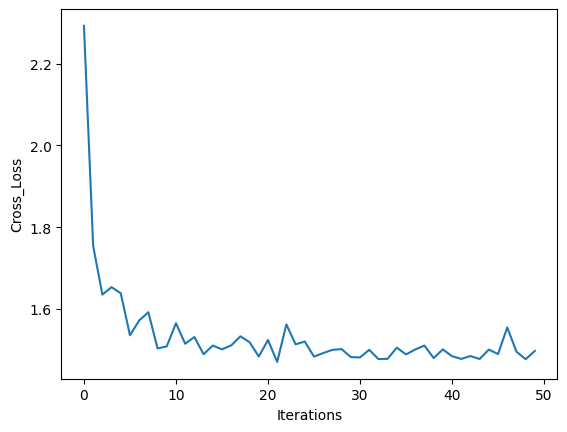

In [13]:
model_cross = MNIST()
losses_cross = train(model_cross)

In [6]:
def evaluation(model, datasets):
    model.eval()

    acc_set = list()
    for batch_id, data in enumerate(datasets()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        pred = model(images)   # 获取预测值
        acc = paddle.metric.accuracy(input=pred, label=labels)
        acc_set.extend(acc.numpy())
    
    # #计算多个batch的准确率
    acc_val_mean = np.array(acc_set).mean()
    return acc_val_mean

In [34]:
acc_of_Cross = evaluation(model_cross, test_loader)
print(f'acc_of_Cross:{acc_of_Cross}')

acc_of_Cross:0.9639729261398315


In [26]:
class MNIST_L2(paddle.nn.Layer):
    def __init__(self):
        super(MNIST_L2, self).__init__()
        # 还是两层隐藏层的网络
        self.fc1 = Linear(in_features=784, out_features=200)
        self.fc2 = Linear(in_features=200, out_features=200)
        # 输出一个维度，使用均方差作为损失
        self.fc3 = Linear(in_features=200, out_features=1)

    def forward(self, inputs):
        inputs = paddle.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs1 = F.sigmoid(outputs1)
        outputs2 = self.fc2(outputs1)
        outputs2 = F.sigmoid(outputs2)
        outputs_final = self.fc3(outputs2)
        # 使用softmax激活
        return outputs_final

In [27]:
model_L2 = MNIST_L2()
params_info = paddle.summary(model_L2, (1, 1, 28, 28))
print(params_info)

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-19         [[1, 784]]            [1, 200]           157,000    
   Linear-20         [[1, 200]]            [1, 200]           40,200     
   Linear-21         [[1, 200]]             [1, 1]              201      
Total params: 197,401
Trainable params: 197,401
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.75
Estimated Total Size (MB): 0.76
---------------------------------------------------------------------------

{'total_params': 197401, 'trainable_params': 197401}


In [29]:
#
def train_L2(model):
    model.train()
    
    opt = paddle.optimizer.SGD(learning_rate=0.1, parameters=model.parameters())
    EPOCH_NUM = 10

    loss_list = []
    
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data

            images = paddle.to_tensor(images)

            labels = paddle.to_tensor(labels, dtype='float32')
            
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)

            #每训练200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                loss_list.append(avg_loss.numpy()[0])
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()

    import matplotlib.pyplot as plt
    plot_x = np.arange(len(loss_list))
    plot_y = np.array(loss_list)
    plt.plot(plot_x, plot_y)
    plt.xlabel('Iterations')
    plt.ylabel('L2_Loss')
    plt.show()
    #保存模型参数
    return loss_list



epoch: 0, batch: 0, loss is: [28.982698]
epoch: 0, batch: 200, loss is: [9.74581]
epoch: 0, batch: 400, loss is: [6.6815624]
epoch: 0, batch: 600, loss is: [8.644201]
epoch: 0, batch: 800, loss is: [8.437513]
epoch: 1, batch: 0, loss is: [9.052108]
epoch: 1, batch: 200, loss is: [7.588226]
epoch: 1, batch: 400, loss is: [10.583775]
epoch: 1, batch: 600, loss is: [4.777327]
epoch: 1, batch: 800, loss is: [3.5551045]
epoch: 2, batch: 0, loss is: [2.9905267]
epoch: 2, batch: 200, loss is: [2.3216884]
epoch: 2, batch: 400, loss is: [2.48175]
epoch: 2, batch: 600, loss is: [2.4494975]
epoch: 2, batch: 800, loss is: [2.0318267]
epoch: 3, batch: 0, loss is: [1.361706]
epoch: 3, batch: 200, loss is: [1.4989141]
epoch: 3, batch: 400, loss is: [2.4652743]
epoch: 3, batch: 600, loss is: [1.492069]
epoch: 3, batch: 800, loss is: [3.2164521]
epoch: 4, batch: 0, loss is: [2.7674537]
epoch: 4, batch: 200, loss is: [1.9094989]
epoch: 4, batch: 400, loss is: [0.9315306]
epoch: 4, batch: 600, loss is: [

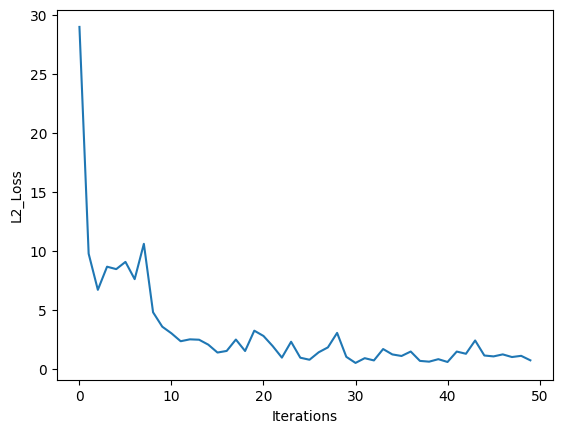

In [30]:
model_L2 = MNIST_L2()
losses_L2 = train_L2(model_L2)

In [33]:
acc_of_L2 = evaluation(model_L2, test_loader)
print(f'acc_of_L2:{acc_of_L2}')

acc_of_L2:0.09783041477203369


In [40]:
import matplotlib.pyplot as plt
def plot_two_losses(loss_list_1, loss_list_2):
    plt.figure(figsize=(10,5))
    
    freqs = [i for i in range(len(loss_list_1))]

    # 绘制训练损失变化曲线
    plt.plot(freqs, loss_list_1, color='#e4007f', label="Train loss_Cross")
    plt.plot(freqs, loss_list_2, color='#f19ec2', linestyle='--', label="Train loss_dropout")
    
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("freq", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')
    
    plt.show()

#plot_two_losses(losses_cross, losses_L2)

In [35]:
# dropout 正则化
class MNIST_DROUPOUT(paddle.nn.Layer):
    def __init__(self, dropout_prob=0.5):
        super(MNIST_DROUPOUT, self).__init__()
        # 还是两层隐藏层的网络
        self.fc1 = Linear(in_features=784, out_features=200)
        self.fc2 = Linear(in_features=200, out_features=200)
        # 输出一个维度，使用均方差作为损失
        self.fc3 = Linear(in_features=200, out_features=10)
        self.dropout = paddle.nn.Dropout(p=dropout_prob)

    def forward(self, inputs):
        inputs = paddle.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs1 = F.relu(outputs1)
        outputs1 = self.dropout(outputs1)
        outputs2 = self.fc2(outputs1)
        outputs2 = F.relu(outputs2)
        outputs2 = self.dropout(outputs2)
        outputs3 = self.fc3(outputs2)
        outputs_final = F.softmax(outputs3)
        # 使用softmax激活
        return outputs_final


In [36]:
model_dropout = MNIST_DROUPOUT()
params_info = paddle.summary(model_dropout, (1, 1, 28, 28))
print(params_info)

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-25         [[1, 784]]            [1, 200]           157,000    
   Dropout-1         [[1, 200]]            [1, 200]              0       
   Linear-26         [[1, 200]]            [1, 200]           40,200     
   Linear-27         [[1, 200]]            [1, 10]             2,010     
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
---------------------------------------------------------------------------

{'total_params': 199210, 'trainable_params': 199210}


In [38]:
# 训练,交叉熵损失
def train_dropout(model):
    model.train()

    # 参数配置
    opt = paddle.optimizer.SGD(learning_rate=0.1, parameters=model.parameters())

    EPOCH_NUM = 10
    losses = []

    for epoch_id in range(EPOCH_NUM):
        for batch_id , data in enumerate(train_loader()):
            # 数据准备
            images, labels = data 
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)

            # 前向计算
            predicts = model(images)

            # 采用交叉熵损失函数
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)


            #每训练200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                losses.append(avg_loss.numpy()[0])
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            # 反向
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
    import matplotlib.pyplot as plt
    plot_x = np.arange(len(losses))
    plot_y = np.array(losses)
    plt.plot(plot_x, plot_y)
    plt.xlabel('Iterations')
    plt.ylabel('Cross_Loss_dropout')
    plt.show()

    return losses

epoch: 0, batch: 0, loss is: [2.2887325]
epoch: 0, batch: 200, loss is: [1.8577062]
epoch: 0, batch: 400, loss is: [1.7426085]
epoch: 0, batch: 600, loss is: [1.7360027]
epoch: 0, batch: 800, loss is: [1.6547123]
epoch: 1, batch: 0, loss is: [1.673959]
epoch: 1, batch: 200, loss is: [1.7150393]
epoch: 1, batch: 400, loss is: [1.6486351]
epoch: 1, batch: 600, loss is: [1.6717839]
epoch: 1, batch: 800, loss is: [1.6178193]
epoch: 2, batch: 0, loss is: [1.6969779]
epoch: 2, batch: 200, loss is: [1.572804]
epoch: 2, batch: 400, loss is: [1.5689049]
epoch: 2, batch: 600, loss is: [1.591553]
epoch: 2, batch: 800, loss is: [1.6435899]
epoch: 3, batch: 0, loss is: [1.5613048]
epoch: 3, batch: 200, loss is: [1.5848777]
epoch: 3, batch: 400, loss is: [1.5539463]
epoch: 3, batch: 600, loss is: [1.5614116]
epoch: 3, batch: 800, loss is: [1.5120716]
epoch: 4, batch: 0, loss is: [1.5122583]
epoch: 4, batch: 200, loss is: [1.577311]
epoch: 4, batch: 400, loss is: [1.5832796]
epoch: 4, batch: 600, los

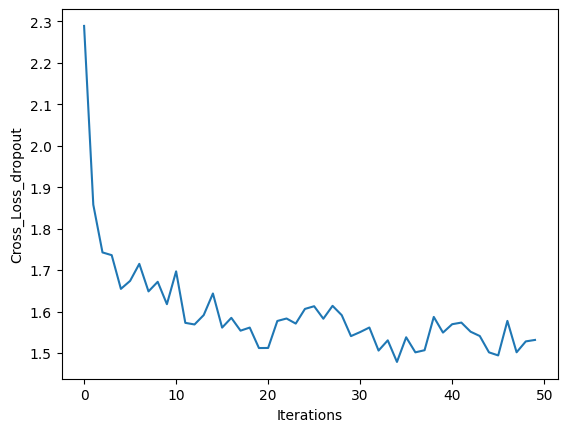

In [39]:
model_dropout = MNIST_DROUPOUT()
losses_dropout = train_dropout(model_dropout)

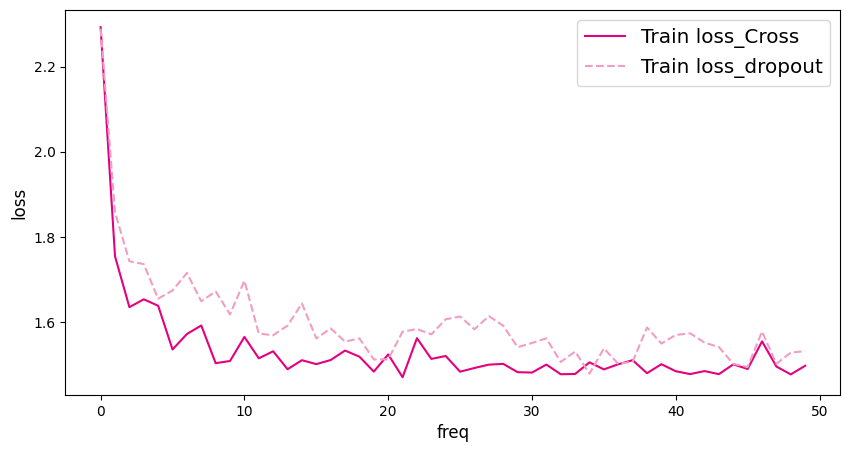

In [41]:
plot_two_losses(losses_cross,losses_dropout)

In [42]:
acc_of_dropout = evaluation(model_dropout, test_loader)
print(f'acc_of_dropout:{acc_of_dropout}')

acc_of_dropout:0.9501393437385559


In [52]:
#仅优化算法的设置有所差别
def train_lr(model):
    model.train()
    losses =[]
    #四种优化算法的设置方案，可以逐一尝试效果
    # opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # opt = paddle.optimizer.Momentum(learning_rate=0.01, momentum=0.9, parameters=model.parameters())
    # opt = paddle.optimizer.Adagrad(learning_rate=0.01, parameters=model.parameters())
    opt = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())
    
    EPOCH_NUM = 3
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                losses.append(avg_loss.numpy()[0])
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()    
    import matplotlib.pyplot as plt
    plot_x = np.arange(len(losses))
    plot_y = np.array(losses)
    plt.plot(plot_x, plot_y)
    plt.xlabel('Iterations')
    plt.ylabel('loss')
    plt.show()
    return losses

    

epoch: 0, batch: 0, loss is: [2.318286]
epoch: 0, batch: 200, loss is: [2.0691323]
epoch: 0, batch: 400, loss is: [1.9572375]
epoch: 0, batch: 600, loss is: [1.9145952]
epoch: 0, batch: 800, loss is: [1.7979087]
epoch: 1, batch: 0, loss is: [1.7017579]
epoch: 1, batch: 200, loss is: [1.7567363]
epoch: 1, batch: 400, loss is: [1.6713634]
epoch: 1, batch: 600, loss is: [1.6950552]
epoch: 1, batch: 800, loss is: [1.6188385]
epoch: 2, batch: 0, loss is: [1.6449437]
epoch: 2, batch: 200, loss is: [1.6225448]
epoch: 2, batch: 400, loss is: [1.6324801]
epoch: 2, batch: 600, loss is: [1.6159554]
epoch: 2, batch: 800, loss is: [1.5660079]


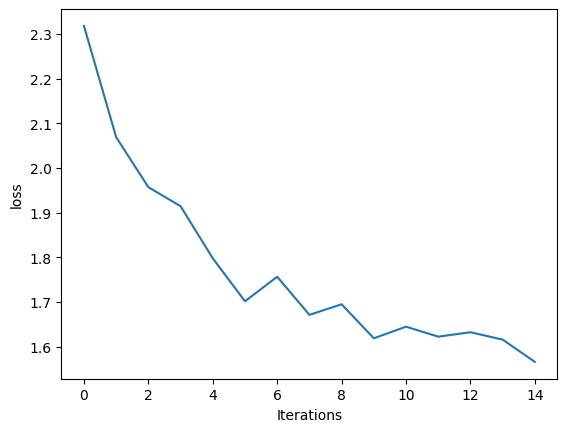

In [46]:
model_lr = MNIST()
losses_opt = train_lr(model_lr)

epoch: 0, batch: 0, loss is: [2.3240917]
epoch: 0, batch: 200, loss is: [2.1582613]
epoch: 0, batch: 400, loss is: [2.0722296]
epoch: 0, batch: 600, loss is: [2.0015593]
epoch: 0, batch: 800, loss is: [1.989963]
epoch: 1, batch: 0, loss is: [1.8494239]
epoch: 1, batch: 200, loss is: [1.8636235]
epoch: 1, batch: 400, loss is: [1.8226253]
epoch: 1, batch: 600, loss is: [1.721472]
epoch: 1, batch: 800, loss is: [1.7576241]
epoch: 2, batch: 0, loss is: [1.7013681]
epoch: 2, batch: 200, loss is: [1.6593752]
epoch: 2, batch: 400, loss is: [1.7128601]
epoch: 2, batch: 600, loss is: [1.7010127]
epoch: 2, batch: 800, loss is: [1.6903609]


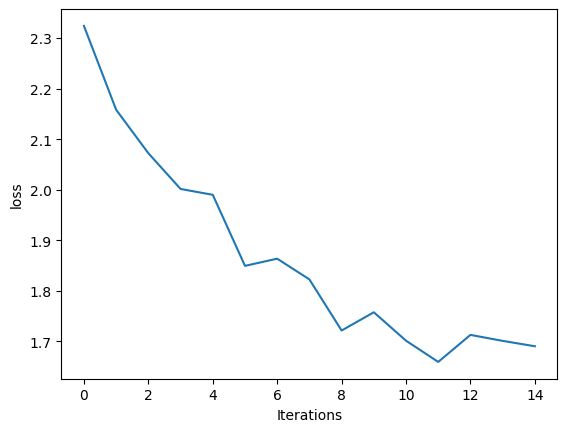

In [47]:
model_Momtem = MNIST()
losses_Momtem = train_lr(model_Momtem)

epoch: 0, batch: 0, loss is: [2.3120565]
epoch: 0, batch: 200, loss is: [2.3674002]
epoch: 0, batch: 400, loss is: [2.2736502]
epoch: 0, batch: 600, loss is: [2.3674002]
epoch: 0, batch: 800, loss is: [2.3986502]
epoch: 1, batch: 0, loss is: [2.3986502]
epoch: 1, batch: 200, loss is: [2.4142752]
epoch: 1, batch: 400, loss is: [2.4142752]
epoch: 1, batch: 600, loss is: [2.3517752]
epoch: 1, batch: 800, loss is: [2.3049002]
epoch: 2, batch: 0, loss is: [2.3830252]
epoch: 2, batch: 200, loss is: [2.3986502]
epoch: 2, batch: 400, loss is: [2.3049002]
epoch: 2, batch: 600, loss is: [2.3674002]
epoch: 2, batch: 800, loss is: [2.3986502]


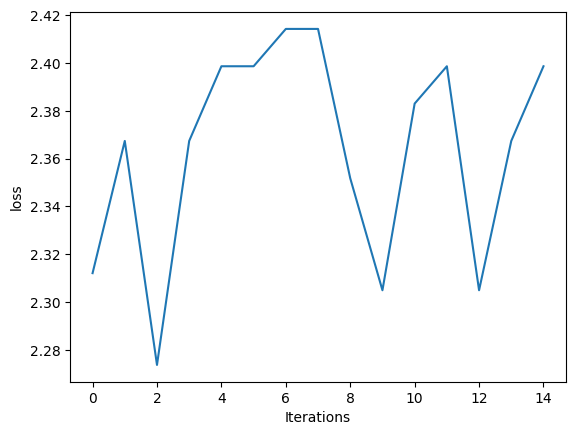

In [51]:
model_Adagrad = MNIST()
losses_Adagrad = train_lr(model_Adagrad)

epoch: 0, batch: 0, loss is: [2.290117]
epoch: 0, batch: 200, loss is: [2.3830252]
epoch: 0, batch: 400, loss is: [2.3205252]
epoch: 0, batch: 600, loss is: [2.3361502]
epoch: 0, batch: 800, loss is: [2.3674002]
epoch: 1, batch: 0, loss is: [2.3205252]
epoch: 1, batch: 200, loss is: [2.3361502]
epoch: 1, batch: 400, loss is: [2.4142752]
epoch: 1, batch: 600, loss is: [2.3986502]
epoch: 1, batch: 800, loss is: [2.3830252]
epoch: 2, batch: 0, loss is: [2.4142752]
epoch: 2, batch: 200, loss is: [2.3517752]
epoch: 2, batch: 400, loss is: [2.3986502]
epoch: 2, batch: 600, loss is: [2.4142752]
epoch: 2, batch: 800, loss is: [2.3517752]


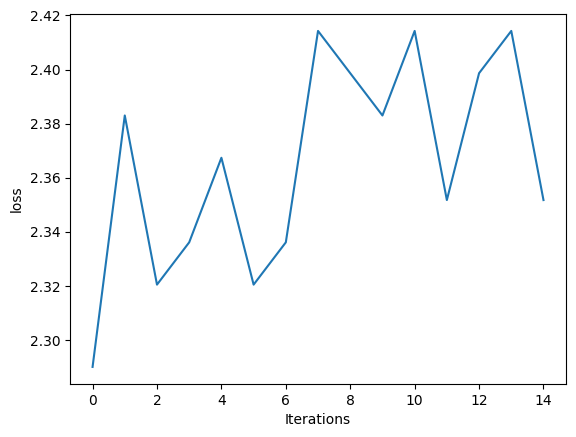

In [53]:
model_Adam = MNIST()
losses_Adam = train_lr(model_Adam)